Implementierung Mithilfe: https://github.com/patrickloeber/snake-ai-pytorch/blob/main/agent.py

Umsetzung: Niclas Cramer (7607733), Niklas Koch (6699912)

# Imports 

In [1]:
import matplotlib.pyplot as plt
from IPython import display
import torch
import random
import numpy as np
from collections import deque
import pygame
from enum import Enum
from collections import namedtuple
import math 

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import os

pygame 2.1.3.dev8 (SDL 2.26.5, Python 3.9.15)
Hello from the pygame community. https://www.pygame.org/contribute.html


# Hilfsfunktion
Nutzung der Hilfsfunktion "plot" zur Visualisierung der Ergebnisse mittels eines Plottes, welche den Durschnitt der Itterationen, sowie der verlauf der Ergebnisse wiedergibt.

In [7]:
plt.ion()

def plot(scores, mean_scores,n_games):
    #display.clear_output(wait=True)
    display.display(plt.gcf())
    plt.clf()
    plt.title('Training...')
    plt.xlabel('Number of Games')
    plt.ylabel('Score')
    plt.plot(scores)
    plt.plot(mean_scores)
    plt.ylim(ymin=0)
    plt.text(len(scores)-1, scores[-1], str(scores[-1]))
    plt.text(len(mean_scores)-1, mean_scores[-1], str(mean_scores[-1]))
    plt.show(block=False)
    plt.pause(.1)
   
    plt.savefig('scores.png')

In [26]:


pygame.init()

font = pygame.font.SysFont('arial', 25)

#definieren der Möglichen Richtungen die die Schlange machen kann
class Direction(Enum):
    RIGHT = 1
    DOWN = 2
    LEFT = 3
    UP = 4
    
Point = namedtuple('Point', 'x, y')

# RGB Farben der verschiedenen Elemente. 
WHITE = (255, 255, 255)
RED = (179,0,0)
GREEN = (0, 153, 0)
YELLOW = (179, 179, 0)
BLACK = (0,0,0)

# initiale Werte für die Größe der Schlange, die Geschwindigkeit und die Größe der Blöcke
BLOCK_SIZE = 40
SPEED = 100

# Klasse für das Spiel
class SnakeGame:
    
    def __init__(self, width=1280, height=960):
        self.width = width
        self.height = height
        # definieren der Displaygröße und des Titels
        self.display = pygame.display.set_mode((self.width, self.height))
        pygame.display.set_caption('Snake')
        self.clock = pygame.time.Clock()
        self.reset()
    
    # reseten des Spiels zur Startposition und zum Startscore von 0
    def reset(self):
        self.direction = Direction.RIGHT
        self.head = Point(self.width/2, self.height/2)
        self.snake = [self.head,
                      Point(self.head.x-BLOCK_SIZE, self.head.y),
                      Point(self.head.x-(2*BLOCK_SIZE), self.head.y)]
        self.score = 0
        self.food = None
        self._place_food()
        self.frame_iteration = 0

    # Platzieren des Essens an einer zufälligen Stelle des Spielfeldes
    def _place_food(self):
        x = random.randint(0, (self.width-BLOCK_SIZE )//BLOCK_SIZE )*BLOCK_SIZE 
        y = random.randint(0, (self.height-BLOCK_SIZE )//BLOCK_SIZE )*BLOCK_SIZE
        self.food = Point(x, y)
        if self.food in self.snake:
            self._place_food()


    
    # Bewegen der Schlange   
    def play_step(self, action):
        self.frame_iteration += 1
        # identifizieren des Inputs des Agenten
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                pygame.quit()
                quit()
        
        # 2. Bewegung der Schlange
        self._move(action) # Updaten der Richtung der Schlange
        self.snake.insert(0, self.head)
        
        # 3. Überprüfen des Spielstatus
        reward = 0
        game_over = False
        if self.is_collision() or self.frame_iteration > 100*len(self.snake):
            game_over = True
            reward = -10
            return reward, game_over, self.score

        # 4. Plazieren des Essens oder entfernen des letzten Elements der Schlange
        if self.head == self.food:
            self.score += 1
            reward = 10
            self._place_food()
        else:
            self.snake.pop()
        
        # 5. Update UI und Uhr
        self._update_ui()
        self.clock.tick(SPEED)
        
        return reward, game_over, self.score

    # Bestimmen, ob die Schlange mit sich selbst oder der Wand kollidiert
    def is_collision(self, pt=None):
        if pt is None:
            pt = self.head
        # Berührt die Wand
        if pt.x > self.width - BLOCK_SIZE or pt.x < 0 or pt.y > self.height - BLOCK_SIZE or pt.y < 0:
            return True
        # Berührt sich selbst
        if pt in self.snake[1:]:
            return True

        return False

    # Updaten des Displays
    def _update_ui(self):
        self.display.fill(BLACK)
        
        for pt in self.snake:
            # Zeichnen der Schlange in der Farbe Grün
            pygame.draw.rect(self.display, GREEN, pygame.Rect(pt.x, pt.y, BLOCK_SIZE, BLOCK_SIZE))
        # Plazieren des Essens in der Farbe Rot    
        pygame.draw.rect(self.display, RED, pygame.Rect(self.food.x, self.food.y, BLOCK_SIZE, BLOCK_SIZE))
       
        text = font.render("Score: " + str(self.score), True, WHITE)
        self.display.blit(text, [0, 0])
        pygame.display.flip()
        
    def _move(self, action):
        # Schritte: Rechts (r), Links (l), Hoch (u ,Vorwärts) basierend auf der Richtung der Schlange. Rückschritte (d) sind nicht möglich, da die Schlange sich nicht selbst essen kann.

        clock_wise = [Direction.RIGHT, Direction.DOWN, Direction.LEFT, Direction.UP]
        idx = clock_wise.index(self.direction)

        if np.array_equal(action, [1, 0, 0]):
            new_dir = clock_wise[idx] # no change
        elif np.array_equal(action, [0, 1, 0]):
            next_idx = (idx + 1) % 4
            new_dir = clock_wise[next_idx] # right turn r -> d -> l -> u
        else: # [0, 0, 1]
            next_idx = (idx - 1) % 4
            new_dir = clock_wise[next_idx] # left turn r -> u -> l -> d

        self.direction = new_dir

        x = self.head.x
        y = self.head.y
        if self.direction == Direction.RIGHT:
            x += BLOCK_SIZE
        elif self.direction == Direction.LEFT:
            x -= BLOCK_SIZE
        elif self.direction == Direction.DOWN:
            y += BLOCK_SIZE
        elif self.direction == Direction.UP:
            y -= BLOCK_SIZE

        self.head = Point(x, y)

# Linear 
Umsetzung eines linearen Modells


In [3]:

# Implementierung des linearen Q-Learning Algorithmus
class Linear_QNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, output_size)
    # Forward Funktion des linearen QNet
    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = self.linear2(x)
        return x
    # Speichern des Modells zur Sicherung der Gewichte
    def save(self, file_name='model_linear.pth'):
        model_folder_path = './model'
        if not os.path.exists(model_folder_path):
            os.makedirs(model_folder_path)

        file_name = os.path.join(model_folder_path, file_name)
        torch.save(self.state_dict(), file_name)

# Implementierung des Trainers für das lineare QNet
class QTrainer:
    def __init__(self, model, lr, gamma):
        self.lr = lr # Lernrate
        self.gamma = gamma # Discountfaktor
        self.model = model # Modell
        self.optimizer = optim.Adam(model.parameters(), lr=self.lr) # Optimizer
        self.criterion = nn.MSELoss() # Loss Funktion des Mean Squared Error

    # Trainingsfunktion des linearen QNets
    def train_step(self, state, action, reward, next_state, game_over):
        state = torch.tensor(state, dtype=torch.float)
        next_state = torch.tensor(next_state, dtype=torch.float)
        action = torch.tensor(action, dtype=torch.long)
        reward = torch.tensor(reward, dtype=torch.float)
   

        if len(state.shape) == 1:

            state = torch.unsqueeze(state, 0)
            next_state = torch.unsqueeze(next_state, 0)
            action = torch.unsqueeze(action, 0)
            reward = torch.unsqueeze(reward, 0)
            game_over = (game_over, )

        # vorhergesagte Q-Werte mit dem aktuellen Zustand
        pred = self.model(state)

        target = pred.clone()
        for idx in range(len(game_over)):
            Q_new = reward[idx]
            if not game_over[idx]:
                Q_new = reward[idx] + self.gamma * torch.max(self.model(next_state[idx]))

            target[idx][torch.argmax(action[idx]).item()] = Q_new
    
        self.optimizer.zero_grad()
        loss = self.criterion(target, pred)
        loss.backward()

        self.optimizer.step()




In [4]:
MAX_MEMORY = 100_000
BATCH_SIZE = 1000
LR = 0.001

# Implementierung des Agenten
class Agent:

    def __init__(self):
        self.num_games = 0
        self.randomness = 0
        self.gamma = 0.9
        self.memory = deque(maxlen=MAX_MEMORY)
        self.model = Linear_QNet(11, 256, 3)
        self.trainer = QTrainer(self.model, lr=LR, gamma=self.gamma)

    # Erhalten des aktuellen Zustands des Spiels
    def get_state(self, game):
        head = game.snake[0]
        point_l = Point(head.x - 40, head.y)
        point_r = Point(head.x + 40, head.y)
        point_u = Point(head.x, head.y - 40)
        point_d = Point(head.x, head.y + 40)
        
        dir_l = game.direction == Direction.LEFT
        dir_r = game.direction == Direction.RIGHT
        dir_u = game.direction == Direction.UP
        dir_d = game.direction == Direction.DOWN

        state = [
            # Gefahr geradeaus
            (dir_r and game.is_collision(point_r)) or 
            (dir_l and game.is_collision(point_l)) or 
            (dir_u and game.is_collision(point_u)) or 
            (dir_d and game.is_collision(point_d)),

            # Gefahr rechts
            (dir_u and game.is_collision(point_r)) or 
            (dir_d and game.is_collision(point_l)) or 
            (dir_l and game.is_collision(point_u)) or 
            (dir_r and game.is_collision(point_d)),

            # Gefahr links
            (dir_d and game.is_collision(point_r)) or 
            (dir_u and game.is_collision(point_l)) or 
            (dir_r and game.is_collision(point_u)) or 
            (dir_l and game.is_collision(point_d)),
            
            # Die Richtung der Schlange
            dir_l,
            dir_r,
            dir_u,
            dir_d,
            
            # Die Position des Essens relativ zur Schlange
            game.food.x < game.head.x,  # Essensposition links
            game.food.x > game.head.x,  # Essensposition rechts
            game.food.y < game.head.y,  # Essensposition oben
            game.food.y > game.head.y  # Essensposition unten
            ]

        return np.array(state, dtype=int)
    # Speichern der Daten in der Memory
    def remember(self, state, action, reward, next_state, game_over):
        self.memory.append((state, action, reward, next_state, game_over)) # popleft if MAX_MEMORY is reached
    # Speichern der Daten in der Memory
    def train_long_memory(self):
        if len(self.memory) > BATCH_SIZE:
            mini_sample = random.sample(self.memory, BATCH_SIZE) # list of tuples
        else:
            mini_sample = self.memory

        states, actions, rewards, next_states, game_overs = zip(*mini_sample)
        self.trainer.train_step(states, actions, rewards, next_states, game_overs)
     
    # Speichern des aktuellen Zustands des Spiels für die nächsten Iteration
    def train_short_memory(self, state, action, reward, next_state, game_over):
        self.trainer.train_step(state, action, reward, next_state, game_over)
    # Erhalten der Aktion des Agenten
    def get_action(self, state):
    
        self.randomness = 100 - self.num_games
        final_move = [0,0,0]
        if random.randint(0, 200) < self.randomness:
            move = random.randint(0, 2)
            final_move[move] = 1
        else:
            state0 = torch.tensor(state, dtype=torch.float)
            prediction = self.model(state0)
            move = torch.argmax(prediction).item()
            final_move[move] = 1

        return final_move

# Trainingsfunktion
def train():
    plot_scores = []
    plot_mean_scores = []
    total_score = 0
    highscore = 0
    agent = Agent()
    game = SnakeGame()
    while True:
        # bekommen des alten Zustands des Spiels
        state_old = agent.get_state(game)

        # bekommen der Aktion des Agenten
        final_move = agent.get_action(state_old)

        # durchführen der Aktion und erhalten des neuen Zustands des Spiels
        reward, game_over, score = game.play_step(final_move)
        state_new = agent.get_state(game)

        # trianieren der kurzen Memory
        agent.train_short_memory(state_old, final_move, reward, state_new, game_over)

        # Referrenzieren der vorherigen Aktionen
        agent.remember(state_old, final_move, reward, state_new, game_over)
        #beenden des Spiels
        if game_over:
            # Speichern im long-term Memory
            game.reset()
            agent.num_games += 1
            agent.train_long_memory()
            # Speichern des Highscores, wenn der aktuelle Score höher ist
            if score > highscore:
                highscore = score
                agent.model.save()
            # Ausgabe des aktuellen Scores, des Highscores und des aktuellen Spiels
            if agent.num_games % 20 == 0:
                print('Game:', agent.num_games, 'Score:', score, 'Highscore:', highscore,'Durschnittswert:', round(plot_mean_scores[-1],4))
            # Speichern der Scores für die Ausgabe
            plot_scores.append(score)
            total_score += score
            mean_score = total_score / agent.num_games
            plot_mean_scores.append(mean_score)
        # Beenden des Trainings nach 500 Spielen
        if agent.num_games > 499:
            # Ausgabe des Plots
            plot(plot_scores, plot_mean_scores, agent.num_games)
            break


Game: 20 Score: 0 Highscore: 1 Durschnittswert: 0.4211
Game: 40 Score: 0 Highscore: 2 Durschnittswert: 0.5897
Game: 60 Score: 1 Highscore: 3 Durschnittswert: 0.7119
Game: 80 Score: 4 Highscore: 4 Durschnittswert: 0.7215
Game: 100 Score: 20 Highscore: 20 Durschnittswert: 1.2626
Game: 120 Score: 49 Highscore: 51 Durschnittswert: 6.1681
Game: 140 Score: 26 Highscore: 58 Durschnittswert: 10.777
Game: 160 Score: 29 Highscore: 58 Durschnittswert: 13.2201
Game: 180 Score: 41 Highscore: 61 Durschnittswert: 15.5307
Game: 200 Score: 34 Highscore: 61 Durschnittswert: 17.4724
Game: 220 Score: 53 Highscore: 61 Durschnittswert: 18.8995
Game: 240 Score: 38 Highscore: 61 Durschnittswert: 19.9247
Game: 260 Score: 34 Highscore: 72 Durschnittswert: 20.9228
Game: 280 Score: 29 Highscore: 72 Durschnittswert: 21.7599
Game: 300 Score: 24 Highscore: 72 Durschnittswert: 22.8562
Game: 320 Score: 23 Highscore: 73 Durschnittswert: 23.3041
Game: 340 Score: 28 Highscore: 73 Durschnittswert: 23.944
Game: 360 Score: 

<Figure size 640x480 with 0 Axes>

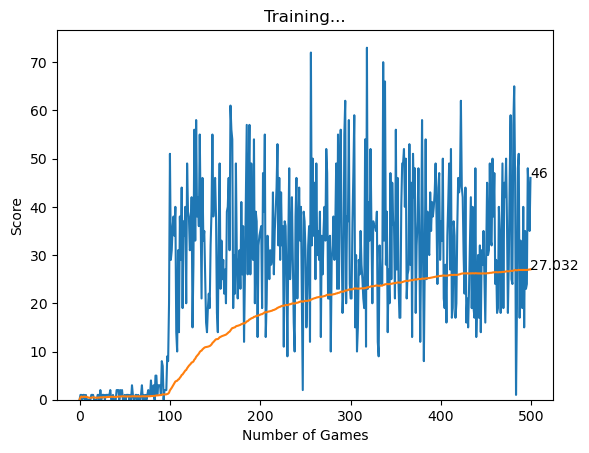

<Figure size 640x480 with 0 Axes>

In [43]:
# Ausführen des Trainings des linearen Q-Learning Algorithmus
train()

# DQN

In [44]:
# Definieren des Deep Q-Learning Algorithmus
class DQN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
    # Forward Funktion des Deep QNets
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    # Speichern des Modells zur Sicherung der Gewichte
    def save(self, file_name='model_DQN.pth'):
        model_folder_path = './model'
        if not os.path.exists(model_folder_path):
            os.makedirs(model_folder_path)

        file_name = os.path.join(model_folder_path, file_name)
        torch.save(self.state_dict(), file_name)

# Implementierung des Trainers für das Deep QNet
class DQTrainer:
    def __init__(self, model, lr, gamma):
        self.lr = lr # Lernrate
        self.gamma = gamma # Discountfaktor
        self.model = model # Modell
        self.optimizer = optim.Adam(model.parameters(), lr=self.lr) # Optimizer
        self.criterion = nn.MSELoss() # Loss Funktion des Mean Squared Error

    # Trainingsfunktion des Deep QNets
    def train_step(self, state, action, reward, next_state, game_over):
        state = torch.tensor(state, dtype=torch.float)
        next_state = torch.tensor(next_state, dtype=torch.float)
        action = torch.tensor(action, dtype=torch.long)
        reward = torch.tensor(reward, dtype=torch.float)



        if len(state.shape) == 1:
            state = torch.unsqueeze(state, 0)
            next_state = torch.unsqueeze(next_state, 0)
            action = torch.unsqueeze(action, 0)
            reward = torch.unsqueeze(reward, 0)
            game_over = (game_over, )
            
        # vorhergesagte Q-Werte mit dem aktuellen Zustand
        pred = self.model(state)
        next_pred = self.model(next_state)
        target = pred.clone()

        for i in range(len(game_over)):
            Q_new = reward[i]
            if not game_over[i]:
                Q_new = reward[i] + self.gamma * torch.max(next_pred[i])

            target[i][action[i]] = Q_new
    
        self.optimizer.zero_grad()
        loss = self.criterion(target, pred)
        loss.backward()
        self.optimizer.step()




In [45]:
MAX_MEMORY = 100000
BATCH_SIZE = 1000
LR = 0.001

# Implementierung des Agenten
class Agent:

    def __init__(self):
        self.num_games = 0
        self.randomness = 0
        self.gamma = 0.9
        self.memory = deque(maxlen=MAX_MEMORY)
        self.model = DQN(11, 256, 3)
        self.trainer = DQTrainer(self.model, lr=LR, gamma=self.gamma)

    # Erhalten des aktuellen Zustands des Spiels
    def get_state(self, game):
        head = game.snake[0]
        point_l = Point(head.x - 40, head.y)
        point_r = Point(head.x + 40, head.y)
        point_u = Point(head.x, head.y - 40)
        point_d = Point(head.x, head.y + 40)
        
        dir_l = game.direction == Direction.LEFT
        dir_r = game.direction == Direction.RIGHT
        dir_u = game.direction == Direction.UP
        dir_d = game.direction == Direction.DOWN

        state = [
            # Gefahr geradeaus
            (dir_r and game.is_collision(point_r)) or 
            (dir_l and game.is_collision(point_l)) or 
            (dir_u and game.is_collision(point_u)) or 
            (dir_d and game.is_collision(point_d)),

            # Gefahr rechts
            (dir_u and game.is_collision(point_r)) or 
            (dir_d and game.is_collision(point_l)) or 
            (dir_l and game.is_collision(point_u)) or 
            (dir_r and game.is_collision(point_d)),

            # Gefahr links
            (dir_d and game.is_collision(point_r)) or 
            (dir_u and game.is_collision(point_l)) or 
            (dir_r and game.is_collision(point_u)) or 
            (dir_l and game.is_collision(point_d)),
            
            # Die Richtung der Schlange
            dir_l,
            dir_r,
            dir_u,
            dir_d,
            
            # Die Position des Essens relativ zur Schlange
            game.food.x < game.head.x,  # Essensposition links
            game.food.x > game.head.x,  # Essensposition rechts
            game.food.y < game.head.y,  # Essensposition oben
            game.food.y > game.head.y  # Essensposition unten
            ]

        return np.array(state, dtype=int)
    # Speichern der Daten in der Memory
    def remember(self, state, action, reward, next_state, game_over):
        self.memory.append((state, action, reward, next_state, game_over)) # popleft if MAX_MEMORY is reached
    # Speichern der Daten in der Memory
    def train_long_memory(self):
        if len(self.memory) > BATCH_SIZE:
            mini_sample = random.sample(self.memory, BATCH_SIZE) # list of tuples
        else:
            mini_sample = self.memory

        states, actions, rewards, next_states, game_overs = zip(*mini_sample)
        self.trainer.train_step(states, actions, rewards, next_states, game_overs)
     
    # Speichern des aktuellen Zustands des Spiels für die nächsten Iteration
    def train_short_memory(self, state, action, reward, next_state, game_over):
        self.trainer.train_step(state, action, reward, next_state, game_over)
    # Erhalten der Aktion des Agenten
    def get_action(self, state):
    
        self.randomness = 100 - self.num_games
        final_move = [0,0,0]
        if random.randint(0, 200) < self.randomness:
            move = random.randint(0, 2)
            final_move[move] = 1
        else:
            state0 = torch.tensor(state, dtype=torch.float)
            prediction = self.model(state0)
            move = torch.argmax(prediction).item()
            final_move[move] = 1

        return final_move

# Trainingsfunktion
def train():
    plot_scores = []
    plot_mean_scores = []
    total_score = 0
    highscore = 0
    agent = Agent()
    game = SnakeGame()
    while True:
        # bekommen des alten Zustands des Spiels
        state_old = agent.get_state(game)

        # bekommen der Aktion des Agenten
        final_move = agent.get_action(state_old)

        # durchführen der Aktion und erhalten des neuen Zustands des Spiels
        reward, game_over, score = game.play_step(final_move)
        state_new = agent.get_state(game)

        # trianieren der kurzen Memory
        agent.train_short_memory(state_old, final_move, reward, state_new, game_over)

        # Referrenzieren der vorherigen Aktionen
        agent.remember(state_old, final_move, reward, state_new, game_over)
        #beenden des Spiels
        if game_over:
            # Speichern im long-term Memory
            game.reset()
            agent.num_games += 1
            agent.train_long_memory()
            # Speichern des Highscores, wenn der aktuelle Score höher ist
            if score > highscore:
                highscore = score
                agent.model.save()
            # Ausgabe des aktuellen Scores, des Highscores und des aktuellen Spiels
            if agent.num_games % 20 == 0:
                print('Game:', agent.num_games, 'Score:', score, 'Highscore:', highscore,'Durschnittswert:', round(plot_mean_scores[-1],4))

            # Speichern der Scores für die Ausgabe
            plot_scores.append(score)
            total_score += score
            mean_score = total_score / agent.num_games
            plot_mean_scores.append(mean_score)
        # Beenden des Trainings nach 500 Spielen
        if agent.num_games > 499:
            # Ausgabe des Plots
            plot(plot_scores, plot_mean_scores, agent.num_games)
            break
           

Game: 20 Score: 0 Highscore: 1 Durschnittswert: 0.0526
Game: 40 Score: 1 Highscore: 1 Durschnittswert: 0.0513
Game: 60 Score: 0 Highscore: 1 Durschnittswert: 0.1186
Game: 80 Score: 0 Highscore: 1 Durschnittswert: 0.1266
Game: 100 Score: 0 Highscore: 1 Durschnittswert: 0.1212
Game: 120 Score: 0 Highscore: 1 Durschnittswert: 0.1092
Game: 140 Score: 0 Highscore: 1 Durschnittswert: 0.1007
Game: 160 Score: 0 Highscore: 1 Durschnittswert: 0.1132
Game: 180 Score: 0 Highscore: 1 Durschnittswert: 0.1285
Game: 200 Score: 0 Highscore: 1 Durschnittswert: 0.1357
Game: 220 Score: 1 Highscore: 1 Durschnittswert: 0.1279
Game: 240 Score: 0 Highscore: 1 Durschnittswert: 0.1381
Game: 260 Score: 0 Highscore: 1 Durschnittswert: 0.1351
Game: 280 Score: 0 Highscore: 1 Durschnittswert: 0.1434
Game: 300 Score: 0 Highscore: 1 Durschnittswert: 0.1472
Game: 320 Score: 1 Highscore: 1 Durschnittswert: 0.1442
Game: 340 Score: 0 Highscore: 1 Durschnittswert: 0.1386
Game: 360 Score: 0 Highscore: 1 Durschnittswert: 0.1

<Figure size 640x480 with 0 Axes>

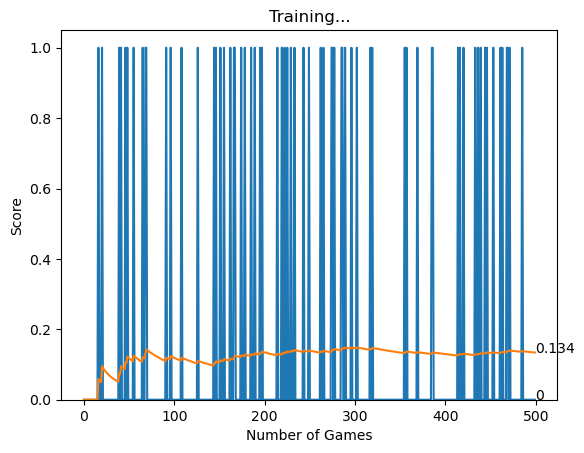

<Figure size 640x480 with 0 Axes>

In [46]:
# Ausführen des Trainings des Deep Q-Learning Algorithmus
train()

# Anpassen der Reward-Funktion

In [8]:
pygame.init()

font = pygame.font.SysFont('arial', 25)

#definieren der Möglichen Richtungen die die Schlange machen kann
class Direction(Enum):
    RIGHT = 1
    DOWN = 2
    LEFT = 3
    UP = 4
    
Point = namedtuple('Point', 'x, y')

# RGB Farben der verschiedenen Elemente. 
WHITE = (255, 255, 255)
RED = (179,0,0)
GREEN = (0, 153, 0)
YELLOW = (179, 179, 0)
BLACK = (0,0,0)

# initiale Werte für die Größe der Schlange, die Geschwindigkeit und die Größe der Blöcke
BLOCK_SIZE = 40
SPEED = 100

# Klasse für das Spiel
class SnakeGame:
    
    def __init__(self, width=1280, height=960):
        self.width = width
        self.height = height
        # definieren der Displaygröße und des Titels
        self.display = pygame.display.set_mode((self.width, self.height))
        pygame.display.set_caption('Snake')
        self.clock = pygame.time.Clock()
        self.reset()
    
    # reseten des Spiels zur Startposition und zum Startscore von 0
    def reset(self):
        self.direction = Direction.RIGHT
        self.head = Point(self.width/2, self.height/2)
        self.snake = [self.head,
                      Point(self.head.x-BLOCK_SIZE, self.head.y),
                      Point(self.head.x-(2*BLOCK_SIZE), self.head.y)]
        self.score = 0
        self.food = None
        self._place_food()
        self.frame_iteration = 0
        self.last_distance = self._get_distance(self.head, self.food)
        
    # Platzieren des Essens an einer zufälligen Stelle des Spielfeldes
    def _place_food(self):
        x = random.randint(0, (self.width-BLOCK_SIZE )//BLOCK_SIZE )*BLOCK_SIZE 
        y = random.randint(0, (self.height-BLOCK_SIZE )//BLOCK_SIZE )*BLOCK_SIZE
        self.food = Point(x, y)
        if self.food in self.snake:
            self._place_food()

    def _get_distance(self, point1, point2):
        return math.sqrt((point1.x - point2.x) ** 2 + (point1.y - point2.y) ** 2)

    
    # Bewegen der Schlange   
    def play_step(self, action):
        self.frame_iteration += 1
        # identifizieren des Inputs des Agenten
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                pygame.quit()
                quit()
        
        # 2. Bewegung der Schlange
        self._move(action) # Updaten der Richtung der Schlange
        self.snake.insert(0, self.head)
        
        # 3. Überprüfen des Spielstatus
        reward = 0
        game_over = False
        if self.is_collision() or self.frame_iteration > 100*len(self.snake):
            game_over = True
            reward = -10
            return reward, game_over, self.score
            
        current_distance = self._get_distance(self.head, self.food)
        if current_distance < self.last_distance:
            reward = 1  # Belohnung für das Bewegen in Richtung der Frucht
        else:
            reward = -1  # Bestrafung für das Bewegen weg von der Frucht
        self.last_distance = current_distance

        # 4. Plazieren des Essens oder entfernen des letzten Elements der Schlange
        if self.head == self.food:
            self.score += 1
            reward = 10
            self._place_food()
        else:
            self.snake.pop()
        
        # 5. Update UI und Uhr
        self._update_ui()
        self.clock.tick(SPEED)
        
        return reward, game_over, self.score

    # Bestimmen, ob die Schlange mit sich selbst oder der Wand kollidiert
    def is_collision(self, pt=None):
        if pt is None:
            pt = self.head
        # Berührt die Wand
        if pt.x > self.width - BLOCK_SIZE or pt.x < 0 or pt.y > self.height - BLOCK_SIZE or pt.y < 0:
            return True
        # Berührt sich selbst
        if pt in self.snake[1:]:
            return True

        return False

    # Updaten des Displays
    def _update_ui(self):
        self.display.fill(BLACK)
        
        for pt in self.snake:
            # Zeichnen der Schlange in der Farbe Grün
            pygame.draw.rect(self.display, GREEN, pygame.Rect(pt.x, pt.y, BLOCK_SIZE, BLOCK_SIZE))
        # Plazieren des Essens in der Farbe Rot    
        pygame.draw.rect(self.display, RED, pygame.Rect(self.food.x, self.food.y, BLOCK_SIZE, BLOCK_SIZE))
       
        text = font.render("Score: " + str(self.score), True, WHITE)
        self.display.blit(text, [0, 0])
        pygame.display.flip()
        
    def _move(self, action):
        # Schritte: Rechts (r), Links (l), Hoch (u ,Vorwärts) basierend auf der Richtung der Schlange. Rückschritte (d) sind nicht möglich, da die Schlange sich nicht selbst essen kann.

        clock_wise = [Direction.RIGHT, Direction.DOWN, Direction.LEFT, Direction.UP]
        idx = clock_wise.index(self.direction)

        if np.array_equal(action, [1, 0, 0]):
            new_dir = clock_wise[idx] # no change
        elif np.array_equal(action, [0, 1, 0]):
            next_idx = (idx + 1) % 4
            new_dir = clock_wise[next_idx] # right turn r -> d -> l -> u
        else: # [0, 0, 1]
            next_idx = (idx - 1) % 4
            new_dir = clock_wise[next_idx] # left turn r -> u -> l -> d

        self.direction = new_dir

        x = self.head.x
        y = self.head.y
        if self.direction == Direction.RIGHT:
            x += BLOCK_SIZE
        elif self.direction == Direction.LEFT:
            x -= BLOCK_SIZE
        elif self.direction == Direction.DOWN:
            y += BLOCK_SIZE
        elif self.direction == Direction.UP:
            y -= BLOCK_SIZE

        self.head = Point(x, y)

In [9]:

# Implementierung des linearen Q-Learning Algorithmus
class Linear_QNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, output_size)
    # Forward Funktion des linearen QNet
    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = self.linear2(x)
        return x
    # Speichern des Modells zur Sicherung der Gewichte
    def save(self, file_name='model_linear.pth'):
        model_folder_path = './model'
        if not os.path.exists(model_folder_path):
            os.makedirs(model_folder_path)

        file_name = os.path.join(model_folder_path, file_name)
        torch.save(self.state_dict(), file_name)

# Implementierung des Trainers für das lineare QNet
class QTrainer:
    def __init__(self, model, lr, gamma):
        self.lr = lr # Lernrate
        self.gamma = gamma # Discountfaktor
        self.model = model # Modell
        self.optimizer = optim.Adam(model.parameters(), lr=self.lr) # Optimizer
        self.criterion = nn.MSELoss() # Loss Funktion des Mean Squared Error

    # Trainingsfunktion des linearen QNets
    def train_step(self, state, action, reward, next_state, game_over):
        state = torch.tensor(state, dtype=torch.float)
        next_state = torch.tensor(next_state, dtype=torch.float)
        action = torch.tensor(action, dtype=torch.long)
        reward = torch.tensor(reward, dtype=torch.float)
   

        if len(state.shape) == 1:

            state = torch.unsqueeze(state, 0)
            next_state = torch.unsqueeze(next_state, 0)
            action = torch.unsqueeze(action, 0)
            reward = torch.unsqueeze(reward, 0)
            game_over = (game_over, )

        # vorhergesagte Q-Werte mit dem aktuellen Zustand
        pred = self.model(state)

        target = pred.clone()
        for idx in range(len(game_over)):
            Q_new = reward[idx]
            if not game_over[idx]:
                Q_new = reward[idx] + self.gamma * torch.max(self.model(next_state[idx]))

            target[idx][torch.argmax(action[idx]).item()] = Q_new
    
        self.optimizer.zero_grad()
        loss = self.criterion(target, pred)
        loss.backward()

        self.optimizer.step()




In [10]:
MAX_MEMORY = 100_000
BATCH_SIZE = 1000
LR = 0.001

# Implementierung des Agenten
class Agent:

    def __init__(self):
        self.num_games = 0
        self.randomness = 0
        self.gamma = 0.9
        self.memory = deque(maxlen=MAX_MEMORY)
        self.model = Linear_QNet(11, 256, 3)
        self.trainer = QTrainer(self.model, lr=LR, gamma=self.gamma)

    # Erhalten des aktuellen Zustands des Spiels
    def get_state(self, game):
        head = game.snake[0]
        point_l = Point(head.x - 40, head.y)
        point_r = Point(head.x + 40, head.y)
        point_u = Point(head.x, head.y - 40)
        point_d = Point(head.x, head.y + 40)
        
        dir_l = game.direction == Direction.LEFT
        dir_r = game.direction == Direction.RIGHT
        dir_u = game.direction == Direction.UP
        dir_d = game.direction == Direction.DOWN

        state = [
            # Gefahr geradeaus
            (dir_r and game.is_collision(point_r)) or 
            (dir_l and game.is_collision(point_l)) or 
            (dir_u and game.is_collision(point_u)) or 
            (dir_d and game.is_collision(point_d)),

            # Gefahr rechts
            (dir_u and game.is_collision(point_r)) or 
            (dir_d and game.is_collision(point_l)) or 
            (dir_l and game.is_collision(point_u)) or 
            (dir_r and game.is_collision(point_d)),

            # Gefahr links
            (dir_d and game.is_collision(point_r)) or 
            (dir_u and game.is_collision(point_l)) or 
            (dir_r and game.is_collision(point_u)) or 
            (dir_l and game.is_collision(point_d)),
            
            # Die Richtung der Schlange
            dir_l,
            dir_r,
            dir_u,
            dir_d,
            
            # Die Position des Essens relativ zur Schlange
            game.food.x < game.head.x,  # Essensposition links
            game.food.x > game.head.x,  # Essensposition rechts
            game.food.y < game.head.y,  # Essensposition oben
            game.food.y > game.head.y  # Essensposition unten
            ]

        return np.array(state, dtype=int)
    # Speichern der Daten in der Memory
    def remember(self, state, action, reward, next_state, game_over):
        self.memory.append((state, action, reward, next_state, game_over)) # popleft if MAX_MEMORY is reached
    # Speichern der Daten in der Memory
    def train_long_memory(self):
        if len(self.memory) > BATCH_SIZE:
            mini_sample = random.sample(self.memory, BATCH_SIZE) # list of tuples
        else:
            mini_sample = self.memory

        states, actions, rewards, next_states, game_overs = zip(*mini_sample)
        self.trainer.train_step(states, actions, rewards, next_states, game_overs)
     
    # Speichern des aktuellen Zustands des Spiels für die nächsten Iteration
    def train_short_memory(self, state, action, reward, next_state, game_over):
        self.trainer.train_step(state, action, reward, next_state, game_over)
    # Erhalten der Aktion des Agenten
    def get_action(self, state):
    
        self.randomness = 100 - self.num_games
        final_move = [0,0,0]
        if random.randint(0, 200) < self.randomness:
            move = random.randint(0, 2)
            final_move[move] = 1
        else:
            state0 = torch.tensor(state, dtype=torch.float)
            prediction = self.model(state0)
            move = torch.argmax(prediction).item()
            final_move[move] = 1

        return final_move

# Trainingsfunktion
def train():
    plot_scores = []
    plot_mean_scores = []
    total_score = 0
    highscore = 0
    agent = Agent()
    game = SnakeGame()
    while True:
        # bekommen des alten Zustands des Spiels
        state_old = agent.get_state(game)

        # bekommen der Aktion des Agenten
        final_move = agent.get_action(state_old)

        # durchführen der Aktion und erhalten des neuen Zustands des Spiels
        reward, game_over, score = game.play_step(final_move)
        state_new = agent.get_state(game)

        # trianieren der kurzen Memory
        agent.train_short_memory(state_old, final_move, reward, state_new, game_over)

        # Referrenzieren der vorherigen Aktionen
        agent.remember(state_old, final_move, reward, state_new, game_over)
        #beenden des Spiels
        if game_over:
            # Speichern im long-term Memory
            game.reset()
            agent.num_games += 1
            agent.train_long_memory()
            # Speichern des Highscores, wenn der aktuelle Score höher ist
            if score > highscore:
                highscore = score
                agent.model.save()
            # Ausgabe des aktuellen Scores, des Highscores und des aktuellen Spiels
            if agent.num_games % 20 == 0:
                print('Game:', agent.num_games, 'Score:', score, 'Highscore:', highscore,'Durschnittswert:', round(plot_mean_scores[-1],4))
            # Speichern der Scores für die Ausgabe
            plot_scores.append(score)
            total_score += score
            mean_score = total_score / agent.num_games
            plot_mean_scores.append(mean_score)
        # Beenden des Trainings nach 500 Spielen
        if agent.num_games > 499:
            # Ausgabe des Plots
            plot(plot_scores, plot_mean_scores, agent.num_games)
            break


/var/folders/k3/z_svrdgd6sb9lc9bqdfzp_k00000gn/T/ipykernel_49829/646622856.py:32: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1671696763866/work/torch/csrc/utils/tensor_new.cpp:253.)
  state = torch.tensor(state, dtype=torch.float)


Game: 20 Score: 2 Highscore: 2 Durschnittswert: 0.4737
Game: 40 Score: 9 Highscore: 9 Durschnittswert: 0.8974
Game: 60 Score: 7 Highscore: 9 Durschnittswert: 1.5763
Game: 80 Score: 0 Highscore: 14 Durschnittswert: 2.4051
Game: 100 Score: 26 Highscore: 61 Durschnittswert: 4.7071
Game: 120 Score: 26 Highscore: 61 Durschnittswert: 8.7479
Game: 140 Score: 21 Highscore: 61 Durschnittswert: 11.7194
Game: 160 Score: 20 Highscore: 61 Durschnittswert: 14.3836
Game: 180 Score: 31 Highscore: 61 Durschnittswert: 15.9832
Game: 200 Score: 44 Highscore: 61 Durschnittswert: 17.8291
Game: 220 Score: 33 Highscore: 61 Durschnittswert: 19.2557
Game: 240 Score: 45 Highscore: 61 Durschnittswert: 20.3933
Game: 260 Score: 31 Highscore: 61 Durschnittswert: 21.0965
Game: 280 Score: 39 Highscore: 61 Durschnittswert: 21.7921
Game: 300 Score: 19 Highscore: 62 Durschnittswert: 22.5284
Game: 320 Score: 38 Highscore: 62 Durschnittswert: 22.9091
Game: 340 Score: 44 Highscore: 62 Durschnittswert: 23.4779
Game: 360 Scor

<Figure size 640x480 with 0 Axes>

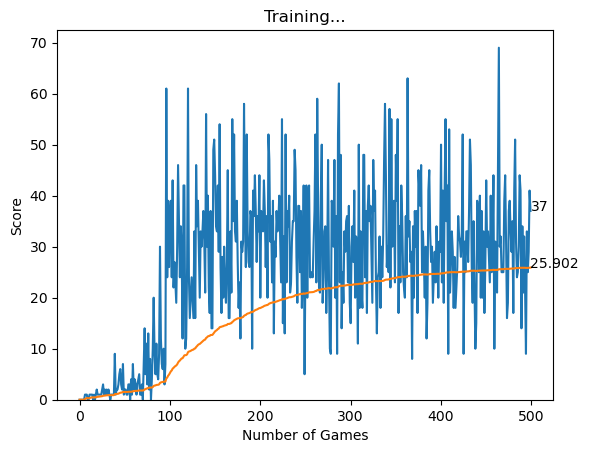

<Figure size 640x480 with 0 Axes>

In [11]:
train()